In [1]:
# This script lauhches the phonon wave-packet in the Au/MNL multilayer structure. 
# Algorithm:
# read the position and velocity data
# sort position data by Z-position

# For Longitudinal acoustic mode, use LA mode frequency from dispersion relation
# Calculate and add displacement in z-direction and velocity in the z-direction as well

# For Transverse acoustic mode along x-dirn, use TAx mode frequency from dispersion relation
# Calculate and add displacement in x-direction and velocity in the x-direction as well

In [2]:
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import cmath

In [3]:
# Definitions:
def bin_averages(bins, array):
    """bins = contains number of lines to average in each bin, dump_bin
       array = contains TE, KE, PE array with each column representing frames"""
    start_idx = 0
    arr_avg = []
    for interval in bins:
        end_idx = start_idx + interval
        subset = array[start_idx:end_idx]
        avg = np.mean(subset, axis=0)
        arr_avg.append(avg)
        start_idx = end_idx
    return np.array(arr_avg)

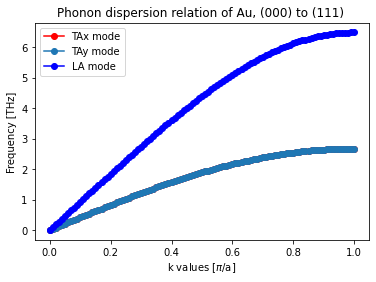

In [4]:
# Reading the phonon dispersion data:
filename = 'Au_morse.disp'
with open(filename, 'r') as file:
    lines = file.readlines()

data = [line.split() for line in lines if not line.startswith('#')]

data = np.array(data)
data = data.astype(np.float64)
cm_2_THz = 29979245800/1e12
TAx = data[0::3][:, 1]*cm_2_THz  # in (cm-1)
TAy = data[1::3][:, 1]*cm_2_THz  # in (cm-1)
LA = data[2::3][:, 1]*cm_2_THz   # in (cm-1)
k_val = (data[0::3][:, 0] - 1)/100

plt.plot(k_val, TAx, 'o-r', label='TAx mode')
plt.plot(k_val, TAy, 'o-', label='TAy mode')
plt.plot(k_val, LA, 'o-b', label='LA mode')
plt.xlabel('k values [$\pi$/a]')
plt.ylabel('Frequency [THz]')
plt.title('Phonon dispersion relation of Au, (000) to (111) ')
plt.legend()
plt.show()

In [5]:
# os.system('ls')

In [6]:
# Input variables:
relaxid = "465613"
ini_vel = 'yes'

# Structural variable:
relaxed_str = f'relaxed_structure_{relaxid}.lmp'

N_atoms = 416640         # Number of atoms
offset_p = 38            # Lines to skip in data file

# Phonon variables:
a0 = 4.079016               # lattice parameter of Au, a = 4.0782(lit), 4.07901835(calc)
A = 0.03                       # Amplitude of the wave in angstrom, 2e-3
eps_k0 = 1                  # e(k0) = Polarization wave vector, why 1?
val = 1                     # 5=0.05, 10 = 0.1, 20 =0.2, 30 = 0.3, 40 = 0.4           
a = a0/np.sqrt(3)            # Case-3
spatial_extent = 140
gamma = spatial_extent*a0    # Spatial extent
wavelength = 2*a/k_val[val]

new_str = f'rlx_{relaxid}_A{A}_k{val}_G_{spatial_extent}a_{ini_vel}vel.lmp'

# Phonon dispersion relation values:
# These values should be obtained from Phonon-dispersion relation of Au 

k0 = k_val[val]*np.pi/a               # wave vector, k0 = 0.9*pi/a
w_LA = 2*np.pi*LA[val]           # in Hz, LA freq corresponding to k0 = 0.9*pi/a
w_TA = 2*np.pi*TAx[val]           # in Hz, TA freq corresponding to k0 = 0.9*pi/a


print("k-value:", k_val[val], "\nLambda:", wavelength,"A", "\nLA freq:", LA[val],"THz", 
      "\nTA freq:", TAx[val], "THz");
# k0 = k0/2
# w_LA = w_LA/2

k-value: 0.01 
Lambda: 471.00419712575814 A 
LA freq: 0.092659703022411 THz 
TA freq: 0.042141735883322595 THz


In [7]:
with open(relaxed_str, "r") as file:   # jid=253256
    lines = file.readlines()
    total_lines = len(lines)
    print('Total lines:', total_lines)

# Read position data:
plines = lines[offset_p:(N_atoms+offset_p)]
# Extract data from line 38 to 384038
position = np.array([list(map(float, line.strip().split())) for line in plines])
print("Shape of position:", position.shape)

# Read velocity data:
offset_v = N_atoms+offset_p + 3
vlines = lines[offset_v:(N_atoms+offset_v)]
# Extract data from line 19 to 358579
velocity = np.array([list(map(float, line.strip().split())) for line in vlines])
print("Shape of velocity:", velocity.shape)

# Read bonds,angles, dihedrals data:
BAD = lines[(N_atoms+offset_v+1):] 

Total lines: 1190450
Shape of position: (416640, 10)
Shape of velocity: (416640, 4)


In [8]:
# Sorting the position according to Z-position:
sorted_index = np.argsort(position[:, 6])
position = position[sorted_index]            # col 4 = x, col 5 = y, col 6 = z

# # Sorting the velocity according to atomid:
# v_index = np.argsort(velocity[:, 0])    # sorting according to atom id
# velocity = velocity[v_index];
# vx = velocity[:, 1]
# vy = velocity[:, 2]
# vz = velocity[:, 3]

Maximum Z-position: 3873.18433548452
Minimum Z-position: -3824.4266417058784


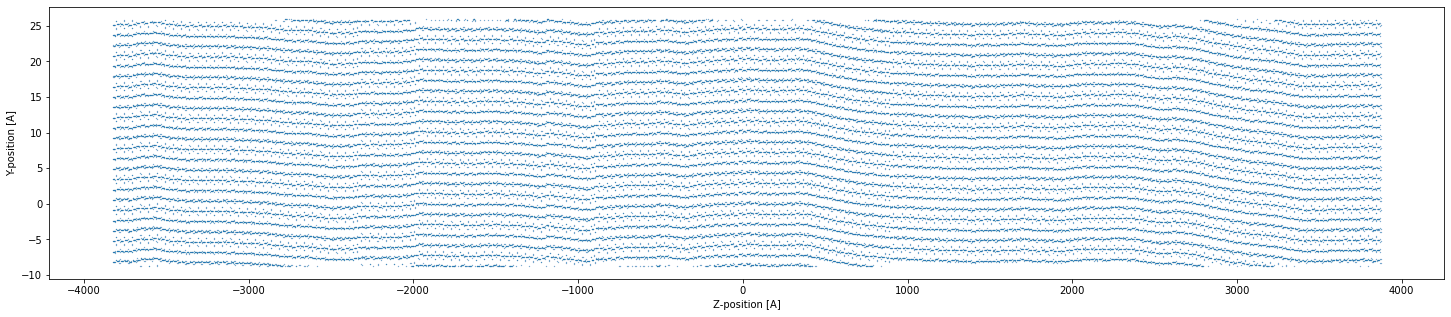

In [9]:
Zhi = np.max(position[:, 6]); print('Maximum Z-position:', Zhi)
Zlo = np.min(position[:, 6]); print('Minimum Z-position:', Zlo)

# position[:, 6] = position[:, 6] - minZ       # shifting the lower limit to zero
# np.savetxt("Z_pos.dat", position[:, 6])
plt.figure(figsize =(25, 5))
plt.plot(position[:, 6], position[:, 4], '.', markersize=0.1)
plt.xlabel('Z-position [A]')
plt.ylabel('Y-position [A]')
plt.show()

Total no. of planes: 4960
Input bilayers: 310
Each bilayers contain: 6 Au layers , 10 Dithiol layers
Total input planes: 4960


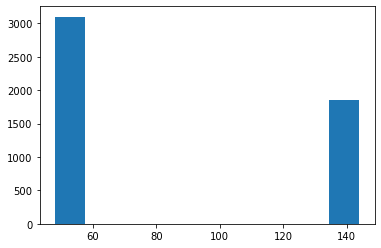

Total Z-atom layers: 4960


In [10]:
# Counting the no. of atoms spatially:
# Here we are counting the number of atoms in each Z-position plane
plane_dist = 0.25                        # Maxm Distance between two plane of atoms
j=0
count = []
for i in range(position[:, 6].shape[0]-1):
    if abs(position[:, 6][i+1] - position[:, 6][i]) < plane_dist:
        j= j+1
    count.append(j)
    j=0
    
count = np.array(count);  
Zeros = np.where(count == 0)[0]+1;         # Counts the position of 0 but with 1 less
bins = Zeros[1:]-Zeros[:-1] ;             # The first and last element is missing
bins = np.concatenate(([Zeros[0]], bins)) # Adding the first element
bins = np.concatenate((bins, [Zeros[-1]-Zeros[-2]]))
print("Total no. of planes:", len(bins))
print("Input bilayers:", 310)
print("Each bilayers contain:", 6, "Au layers ,", 10, "Dithiol layers")
print("Total input planes:", 310*(6+10))
# np.savetxt("bins.dat", bins)

# Checking the correctness of the method with the histogram:
# Note: evaluating the correctness of binning:
# Au_layers: 144 atoms at 0 K
# S and C layers: 48 atoms at 0 K
plt.hist(bins)
plt.show()

Z_atom_layers =  bin_averages(bins, position[:, 6]); 
print("Total Z-atom layers:", Z_atom_layers.shape[0])

In [11]:
# Computing the displacements
xn = Z_atom_layers                   # All positions
x0 = xn[xn.shape[0]//2-0]            # middle of the Au layer, for 2600 A

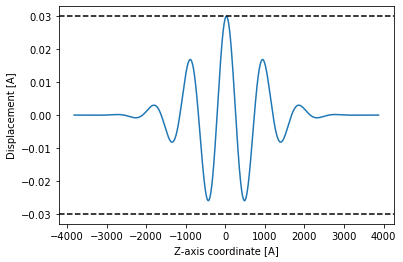

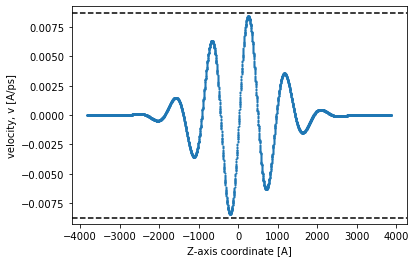

In [12]:
y = 0 + k0*(xn - x0)*1j
disp = A*eps_k0*np.exp(-(xn - x0)**2/gamma**2)*np.exp(y)

# Plot the position
U = np.real(disp)                        # Take the real part for displacement
plt.plot(xn, U, label='real')
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("Displacement [A]")
# plt.xlim(800, 900)
# plt.ylim(-0.2, 0.2)
plt.axhline(A, color='k', ls='--')
plt.axhline(-A, color='k', ls='--')
plt.savefig("Wave-packet_displacement.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
plt.show()


# Plot the velocity
vel = (w_LA*np.imag(disp))           # For LA mode set this as velocity in z-dirn, A/ps            
plt.plot(xn, vel, 'o', markersize='1')
plt.xlabel("Z-axis coordinate [A]")
plt.ylabel("velocity, v [A/ps]")
plt.axhline(A*w_LA, color='k', ls='--')
plt.axhline(-A*w_LA, color='k', ls='--')
plt.savefig("Wave-packet_velocity.png", dpi= 200, bbox_inches = 'tight', facecolor="w")
# plt.xlim(500, 550)
# plt.ylim(-0.5, 0.5)
plt.show()

# np.savetxt("Wave-packet_displacement.dat", U)
# np.savetxt("Wave-packet_velocity.dat", vel) 

In [13]:
# Now lets repeat the values of displacement and velocity according to the spatial bins:
new_pos = np.repeat(U, bins) ; print("Shape of position:", new_pos.shape)
new_vel = np.repeat(vel, bins); print("Shape of velocity:", new_vel.shape)

Shape of position: (416640,)
Shape of velocity: (416640,)


In [14]:
# Now let's do the replacement of both position and velocity:

# position
# Adding displacement to the Z-position 
# new_z = position[:, 6] + new_pos
position[:, 6] = 1.0000000000*new_pos + 1.0000000000*position[:, 6]

phonon_pos = position[:, 0:7]                     # only taking from 0 to 6th column
p_index = np.argsort(phonon_pos[:, 0])
phonon_pos = phonon_pos[p_index]

# velocity of displaced atoms only
# replacing vz component of velocity, vx = vy = 0 A/ps for LA mode
Atom_vel = np.zeros((position.shape[0], 4))
Atom_vel[:, 0] = position[:, 0]                 # atom ids
Atom_vel[:, 1] = np.zeros(position.shape[0])    # vx = 0 A/ps
Atom_vel[:, 2] = np.zeros(position.shape[0])    # vy = 0 A/ps
Atom_vel[:, 3] = np.zeros(position.shape[0])    # vz = 0 A/ps
# Atom_vel[:, 3] = 1.0000000000*new_vel           # vz = computed velocity

# Sorting the velocity according to atomid:
v_index = np.argsort(Atom_vel[:, 0])
Atom_vel = Atom_vel[v_index];

In [15]:
# os.system('rm Au_111_18x10x332*.lmp')

with open(new_str, "w") as output_file:
    
# Writing the structural details, natoms, box size
    for i in range(0, 21):
        output_file.write(lines[i])
    
    for i in range(36, 38):
        output_file.write(lines[i])

# Writing the position of atoms:        
    for item in phonon_pos:   # Atoms with displacement
        output_file.write(str(int(item[0]))+ '\t' + str(int(item[1]))+ '\t' +
                          str(int(item[2]))+ '\t' + 
                          '\t'.join(str(elem) for elem in item[3:]) + '\n')

# Writing velocities:
    output_file.write("\n")
    output_file.write("Velocities"+ "\n")
    output_file.write("\n")    
    for item in Atom_vel:
        output_file.write(str(int(item[0]))+ '\t' + '\t'.join(str(elem) for elem in item[1:]) + '\n')

# Writing bonds, angles, dihedrals        
    output_file.write("\n")
    for i in range((N_atoms+offset_v+1), len(lines)):
        output_file.write(lines[i])
        
    output_file.write("\n")
    
# np.savetxt("Velocity.dat", velocity)
# np.savetxt("Displacement.dat", phonon_pos)


In [16]:
print('Input paramters:')
print('k-value:', k_val[val])
print('Selected frequency:', LA[val], 'THz')
print('Lattice parameter:', a, 'Ang')
print('Center of wave packet:', x0)

Input paramters:
k-value: 0.01
Selected frequency: 0.092659703022411 THz
Lattice parameter: 2.3550209856287907 Ang
Center of wave packet: 25.526398373817756


In [17]:
import glob
import shutil

# Making the directory the wave-packet:
directory_path = os.getcwd()

foldername = f'rlxid_{relaxid}_A{A}_k{val}_G_{spatial_extent}a_{ini_vel}vel'        # Folder name

new_directory_path = os.path.join(directory_path, foldername)
if not os.path.exists(new_directory_path):
    os.makedirs(new_directory_path)

# Move all the *.tif files to the new directory
tif_files = glob.glob("*.png")
for file in tif_files:
    shutil.move(file, os.path.join(new_directory_path, file))

shutil.move(new_str, os.path.join(new_directory_path, new_str))

'/mnt/c/Users/rajan/OneDrive - Missouri State University/Research_scripts/Phonon_thermal_simulation/Au_MNL_b_310/rlxid_465613_A0.03_k1_G_300a_yesvel/rlx_465613_A0.03_k1_G_300a_yesvel.lmp'

In [18]:
# # Sorting the position according to Z-position:
# sorted_index = np.argsort(Au_111_layers[:, 6])
# Au_111_layers = Au_111_layers[sorted_index]            # col 4 = x, col 5 = y, col 6 = z
# np.savetxt("z_disp_vel.dat", np.hstack((Au_111_layers[:, 6][:, None], phonon_pos[:, 6][:, None])))

# # Creating directory and moving file:
# os.system('mkdir A002_k10_abysqrt3')
# os.system('mv *.dat *.png *.lmp A002_k10_abysqrt3')